<a href="https://colab.research.google.com/github/abhijithcprakash/Large_Language_Models/blob/main/Beginners_Guide_to_Text_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Create the Environment

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Embedding
import matplotlib.pyplot as plt

Download Text Data

In [ ]:
file_URL = "https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt"
file_name= "shakespeare.txt"
# get the file path
path = keras.utils.get_file(file_name, file_URL)

1115394/1115394 [==============================] - 0s 0us/step


In [ ]:
raw = open(path, 'rb').read()
print(raw[250:400])

b"\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it "


In [ ]:
text = raw.decode(encoding='utf-8')
print(text[250:400])


All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it 


In [ ]:
len(text)

1115394

Vectorize Word Characters into Integers

In [ ]:
# unique characters
vocabulary = np.array(sorted(set(text)))
len(vocabulary)

65

Define a tokenizer that can convert a text character into a corresponding integer. There will be 65 integers starting from 0 and ending at 64. We can assign integers on our own as per the order of characters in the vocabulary.

In [ ]:
# assign an integer to each character
tokenizer = {char:i for i,char in enumerate(vocabulary)}

In [ ]:
for i in range(20):
  char = vocabulary[i]
  token = tokenizer[char]
  print('%4s : %4d'%(repr(char),token))

'\n' :    0
 ' ' :    1
 '!' :    2
 '$' :    3
 '&' :    4
 "'" :    5
 ',' :    6
 '-' :    7
 '.' :    8
 '3' :    9
 ':' :   10
 ';' :   11
 '?' :   12
 'A' :   13
 'B' :   14
 'C' :   15
 'D' :   16
 'E' :   17
 'F' :   18
 'G' :   19


Vectorize the entire text and check whether the built tokenizer can encode and decode – texts and integers properly.

In [ ]:
vector = np.array([tokenizer[char] for char in text])
print('\nSample Text \n')
print('-'*70)
print(text[:100])
print('-'*70)
print('\n\nCorresponding Integer Vector \n')
print('-'*70)
print(vector[:100])
print('-'*70)


Sample Text 

----------------------------------------------------------------------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You
----------------------------------------------------------------------


Corresponding Integer Vector 

----------------------------------------------------------------------
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59]
----------------------------------------------------------------------


Text with one million encoded characters can not be fed into a model as such. Since we predict characters, the text must be broken down into sequences of some predefined length and then fed into the model. Use TensorFlow’s batch method to create sequences of 100 characters each. Prior to that, convert the NumPy arrays into tensors to make further processes using TensorFlow.

In [ ]:
 # convert into tensors
vector = tf.data.Dataset.from_tensor_slices(vector)
 # make sequences each of length 100 characters
sequences = vector.batch(100, drop_remainder=True)

Recurrent neural networks predict the subsequent characters based on the past characters. RNNs require a sequence of input characters and the corresponding target sequence with the subsequent characters for training. Prepare input sequences with the first 99 characters and corresponding target sequences with the last 99 characters.

In [ ]:
def prepare_dataset(seq):
  input_vector = seq[:-1]
  target_vector = seq[1:]
  return input_vector, target_vector
dataset = sequences.map(prepare_dataset)

In [ ]:
# check how it looks
for inp, tar in dataset.take(1):
  print(inp.numpy())
  print(tar.numpy())
  inp_text = ''.join(vocabulary[inp])
  tar_text = ''.join(vocabulary[tar])
  print(repr(inp_text))
  print(repr(tar_text))

[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53]
[47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43  1
 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43 39
 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49  6
  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0
 37 53 59]
'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYo'
'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'


Model will be trained with Stochastic Gradient Descent (SGD) based optimizer Adam. It requires the input data to be batched. Further, TensorFlow’s prefetch method helps training with optimized memory. It fetches data batches just before the training requires them. We prefer not to shuffle the data to retain the contextual order of sequences.

In [ ]:
 AUTOTUNE = tf.data.AUTOTUNE
 # buffer size 10000
 # batch size 64
 data = dataset.batch(64, drop_remainder=True).repeat()
 data = data.prefetch(AUTOTUNE)
 # steps per epoch is number of batches available
 STEPS_PER_EPOCH = len(sequences)//64
 for inp, tar in data.take(1):
     print(inp.numpy().shape)
     print(tar.numpy().shape)

(64, 99)
(64, 99)


Build an RNN Model

Recurrent neural networks are good at modeling time-dependent data because of its ability to retain time-steps based information in memory. Since texts have contextual information that are determined purely by order of the words, natural language processing heavily relies on sequence modeling architectures such as RNN. Here, an LSTM (Long Short-Term Memory) layers-based recurrent neural network is developed to model the task. While implementing LSTM layers, we enable stateful argument as True to keep the time-step memory of previous states while learning with consequent batches in an epoch. It helps capture the context among consecutive sequences.

In [ ]:
model = keras.Sequential([
     # Embed len(vocabulary) into 64 dimensions
     Embedding(len(vocabulary), 64, batch_input_shape=[64,None]),
     # LSTM RNN layers
     LSTM(512, return_sequences=True, stateful=True),
     LSTM(512, return_sequences=True, stateful=True),
     # Classification head
     Dense(len(vocabulary))
 ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 64)            4160      
                                                                 
 lstm (LSTM)                 (64, None, 512)           1181696   
                                                                 
 lstm_1 (LSTM)               (64, None, 512)           2099200   
                                                                 
 dense (Dense)               (64, None, 65)            33345     
                                                                 
Total params: 3,318,401
Trainable params: 3,318,401
Non-trainable params: 0
_________________________________________________________________


Plot the model to understand the flow and shapes of data at each layer’s input and output

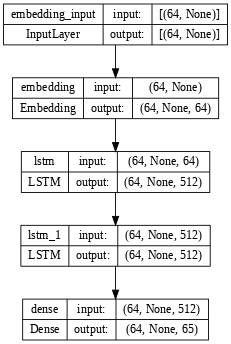

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=64)

Train the RNN Model

We can check whether the model can accept the processed data without any errors.

In [ ]:
# test whether the untrained model performs good
for example_inp, example_tar in data.take(1):
  example_pred = model(example_inp)
  print(example_tar.numpy().shape)
  print(example_pred.shape)

(64, 99)
(64, 99, 65)


The target shape is (64, 99), which refers to the batch size and the number of characters in that sequence. The last shape, 65, in the prediction refers to the size of the vocabulary. The model predicts the probability of occurrence of each character in the vocabulary. The character with a higher probability has more possibility to be the next character.

Compile the model with Adam optimizer and Sparse Categorical Cross-entropy loss function. Since we have not employed softmax as the output layer’s activation function. The outputs will be independent but not mutually exclusive. Hence, we should enable the argument ‘from_logits’ to be True while declaring the loss function. Train the model for 10 epochs.

In [23]:
model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

history = model.fit(data, epochs=500, steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/500
174/174 [==============================] - 13s 55ms/step - loss: 0.3341
Epoch 2/500
174/174 [==============================] - 9s 51ms/step - loss: 0.3254
Epoch 3/500
174/174 [==============================] - 8s 49ms/step - loss: 0.3176
Epoch 4/500
174/174 [==============================] - 9s 49ms/step - loss: 0.3134
Epoch 5/500
174/174 [==============================] - 9s 50ms/step - loss: 0.3102
Epoch 6/500
174/174 [==============================] - 9s 49ms/step - loss: 0.3064
Epoch 7/500
174/174 [==============================] - 9s 50ms/step - loss: 0.3030
Epoch 8/500
174/174 [==============================] - 9s 50ms/step - loss: 0.3003
Epoch 9/500
174/174 [==============================] - 9s 50ms/step - loss: 0.2988
Epoch 10/500
174/174 [==============================] - 9s 51ms/step - loss: 0.2961
Epoch 11/500
174/174 [==============================] - 9s 51ms/step - loss: 0.2966
Epoch 12/500
174/174 [==============================] - 9s 51ms/step - loss: 0.2944


Model Performance Evaluation

Visualizing the losses over epochs may help get better insight on model performance.

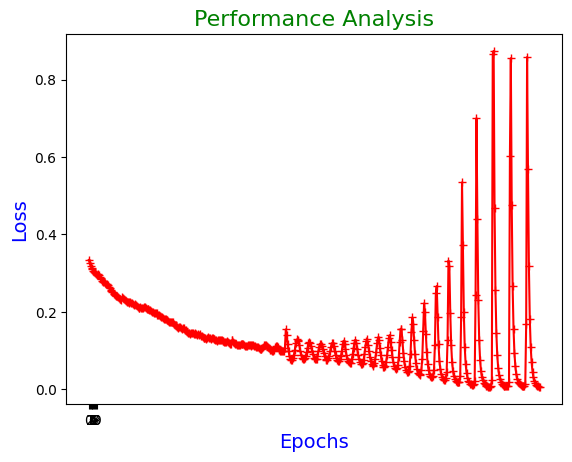

In [24]:
plt.plot(history.history['loss'], '+-r')
plt.title('Performance Analysis', size=16, color='green')
plt.xlabel('Epochs', size=14, color='blue')
plt.ylabel('Loss', size=14, color='blue')
plt.xticks(range(10))
plt.show()

Loss keeps on falling down even till the 10th epoch. It suggests that the model should be trained for more epochs until convergence occurs. The smoothness in the loss curve suggests that the learning rate is proper for this model configuration.

Inference – Next Character Prediction

The most awaited part of this task is predicting the next character with the trained model. We can input the model some characters (probably a word) such that it will iteratively predict the next 1000 characters.

Before starting prediction with the model, we should reset the model states that were stored in the memory during the last epoch training. However, resetting state memories will not affect the model’s weights.

In [25]:
# reset previous states of model
model.reset_states()

 Make predictions by providing the model ‘ANTHONIO:’ as input characters. Nevertheless, the model expects data in three dimensions: the first dimension being the batch size, 64. Vectorize the input characters, expand the dimensions, broadcast the same vector 64 times to obtain a batch of size 64 sequences. Predictions are made based on the logits output by the model. This can be sensitively adjusted by tuning a hyper-parameter called temperature, which refers to the level of randomness in choosing the probable outcome.

In [26]:
sample = 'ANTHONIO:'
# vectorize the string
sample_vector = [tokenizer[s] for s in sample]
predicted = sample_vector
# convert into tensor of required dimensions
sample_tensor = tf.expand_dims(sample_vector, 0)
# broadcast to first dimension to 64
sample_tensor = tf.repeat(sample_tensor, 64, axis=0)

# predict next 1000 characters
# temperature is a sensitive variable to adjust prediction
temperature = 0.6

for i in range(1000):
  pred = model(sample_tensor)
  # reduce unnecessary dimensions
  pred = pred[0].numpy()/temperature
  pred = tf.random.categorical(pred, num_samples=1)[-1,0].numpy()
  predicted.append(pred)
  sample_tensor = predicted[-99:]
  sample_tensor = tf.expand_dims([pred],0)
  # broadcast to first dimension to 64
  sample_tensor = tf.repeat(sample_tensor, 64, axis=0)

# convert the integers back to characters
pred_char = [vocabulary[i] for i in predicted]
generated = ''.join(pred_char)
print(generated)

ANTHONIO:JHjANT:
How doth my hear off, my lord?

PERDITA:
How often he had met you, sword to sword;
That of all things upon the earth he hated
tonher you our courtesy.

ISABELLA:
I garden-house
He knew me as a wife. As this is true,
Let me in safety raise me from my knees
Or else your voices my place in my achil
And of your love and pitiful in the rein: here in the view of men
I will unfold some causes of your brother!
You, Lord of England, look attend you on him as his wife.

All The supsess of her fanthom are cause to speak.

Clown:
What are you, sir?

ELBOW:
He, sir! a tapster, sir; parcius with health and half a melold day.

LUCIO:
My lord, hath some feeling husband, he has with you.

LUCIO:

ISABELLA:
Too late? why, no; I, that drst thy name and crown
To Henry Bolingbroke, the odds of woe?
Never she your sightes and the rapicious head,
And reason with a righteous gentleman!
That I, we are gone shall prove infect another
As is the beggar's poston with it with my heart!

KING EDWARD

By adjusting the temperature value, we can vary randomness and obtain different predictions.


In [27]:
sample = 'ANTHONIO:'
# vectorize the string
sample_vector = [tokenizer[s] for s in sample]
predicted = sample_vector
# convert into tensor of required dimensions
sample_tensor = tf.expand_dims(sample_vector, 0)
# broadcast to first dimension to 64
sample_tensor = tf.repeat(sample_tensor, 64, axis=0)

# predict next 1000 characters
# temperature is a sensitive variable to adjust prediction
temperature = 0.8

for i in range(1000):
  pred = model(sample_tensor)
  # reduce unnecessary dimensions
  pred = pred[0].numpy()/temperature
  pred = tf.random.categorical(pred, num_samples=1)[-1,0].numpy()
  predicted.append(pred)
  sample_tensor = predicted[-99:]
  sample_tensor = tf.expand_dims([pred],0)
  # broadcast to first dimension to 64
  sample_tensor = tf.repeat(sample_tensor, 64, axis=0)

# convert the integers back to characters
pred_char = [vocabulary[i] for i in predicted]
generated = ''.join(pred_char)
print(generated)

ANTHONIO:
Sir, what are you that offer to beat my soul; let's hence;
And better will they follow in
The murder; and yet still shall marry him with her.
Put not a visitation for her limit of it.

PAULINA:
That
Shalt with all my love to give So, but sting the rest rest
dies made him sayot; but I will weep the
singleness or praise me now my father's door,
Who, with a gronger thing before and Englilia,
With his tongue viol with her that she make hand
o here were he that kson her gr str business now our country I
Or it extruch for your high perform itself.

PETRUCHIO:
Villain, I say, knock me at this gate
And rap me well, or I'll knock your king's, my duke?

CAPULET:
Poor sint
'I' as horse is come to him at least.

ISABELLA:
I garden-house
He knew me as a wife. As this is true,
Let me in safety raise me from my knees
Or else your voices made the office
To each leave to all I gone in work,
Pipath the arm of my mouth is as an ETHARD that are hour at Laurence' cell,
And all my words above, whi